In [2]:
using Pipe

In [3]:
push!(LOAD_PATH, "../word-embeddings2")
using WordEmbeddings


In [4]:
function scalar{T <: Array}(x :: T)
    if length(x) == 1   #  Is the x singleton?
        @inbounds return x[1]
    else
        error("nonsingleton array")
    end
end

scalar (generic function with 1 method)

In [5]:
#mixture of K guassains, each of M dimentions

function EM_init_inner(K::Int64, μs)
    M = size(μs,2)
    
    Σs = [eye(M) for _ in 1:K] #Assume no cross corrlation
    P_ks = ones(K)/K
    
    μs,Σs, P_ks
end

function EM_init(K::Int64, M::Int64)
    μs = randn(K,M)
    EM_init_inner(K, μs)
end


function EM_init(K::Int64, xs)
    μs = xs[randperm(size(xs,1))[1:K],:]
    EM_init_inner(K, μs)
end

EM_init (generic function with 2 methods)

In [6]:
function E_step_naive(xs,μs,Σs,P_ks)
    N,M = size(xs) #Number of datapoints & Dimentionality of the Gaussian
    K = length(P_ks) #Number of gaussians
    
    function P_x↾μ_Σ(x,μ,Σ) #Gaussian density of x being from that gaussain given then gaussians mean etc
        exponanant = -0.5*(x-μ)*Σ^-1*(x-μ)'
        exponanant=scalar(exponanant)
        
        coefficient = 1/√((2π)^M * det(Σ))
        coefficient* e^(exponanant)
    end    
        
    P_x↾ks::Matrix{Number}=[P_x↾μ_Σ(xs[n,:],μs[k,:],Σs[k]) 
                for n in 1:N, k in 1:K]
                
    P_xs=P_x↾ks*P_ks
    
    L = prod(P_xs)
    P_x↾ks,P_ks,P_xs
    P_k↾xs::Matrix{Number} =  [P_x↾ks[n,k]*P_ks[k]/P_xs[n] for n in 1:N,  k in 1:K]
    
    L,P_k↾xs
end    

E_step_naive (generic function with 1 method)

In [7]:
function E_step(xs,μs,Σs,P_ks)
    lP_ks = log(P_ks)
    
    N,M = size(xs) #Number of datapoints & Dimentionality of the Gaussian
    K = length(P_ks) #Number of gaussians
    
    function lf_x↾μ_Σ(x,μ,Σ) #Gaussian density of x being from that gaussain given then gaussians mean etc
        exponanant = -0.5*(x-μ)*Σ^-1*(x-μ)'
        exponanant = scalar(exponanant)
        exponanant - M/2*log(2π) - 0.5*log(det(Σ))
    end    
    
    
    lf_x↾ks::Matrix{Number}=[lf_x↾μ_Σ(xs[n,:],μs[k,:],Σs[k]) 
                for n in 1:N, k in 1:K]
        
    zP_xs=hcat([lf_x↾ks[:,k].+lP_ks[k,:] for k in 1:K]...)
    zMax = maximum(zP_xs,2)
    lP_xs = zMax+log(sum(e.^(zP_xs.-zMax),2))
    
    L=prod(e.^map(BigFloat,lP_xs))
    #lL = sum(lP_xs)
    
    lP_k↾xs::Matrix{Number}  = [lf_x↾ks[n,k]+lP_ks[k]-lP_xs[n] for n in 1:N,  k in 1:K]
    L,e.^lP_k↾xs,e.^lP_xs
end    

E_step (generic function with 1 method)

In [8]:
function M_step(xs, P_k↾xs)
    K=size(P_k↾xs,2)
    N = size(xs,1)
    
    μs = vcat([sum([P_k↾xs[n,k]*xs[n,:] for n in 1:N])/sum(P_k↾xs,1)[k] for k in 1:K]...)
    Σs=[sum([P_k↾xs[n,k]*(xs[n,:]-μs[k,:])'*(xs[n,:]-μs[k,:]) for n in 1:N])/sum(P_k↾xs,1)[k] for k in 1:K]
    
    P_ks = squeeze(1/N*sum(P_k↾xs,1)',2)
    μs,Σs, P_ks
end

M_step (generic function with 1 method)

In [9]:
function EM(xs,K, max_iter, min_improve=0.0, callback=(xs, μs, Σs, P_ks, L,P_k↾xs) -> nothing)
    μs,Σs, P_ks = EM_init(K,xs)
    
    past_L = -Inf
    for ii in 1:max_iter
        L,P_k↾xs=E_step(xs, μs,Σs, P_ks)
        ll = log
        println("$ii: $(L) : $L")
        if L-past_L<min_improve
        #    break
        end
        past_L=L
        callback(xs, μs, Σs, P_ks, L,P_k↾xs)
        μs,Σs, P_ks= M_step(xs, P_k↾xs)

    end
    return μs,Σs
end

EM (generic function with 3 methods)

In [10]:
we = @pipe load_embeddings("../word-embeddings2/word_emb_data/embeddings-scaled.EMBEDDING_SIZE=50.txt") |> WE(_...);

In [11]:
wes = we.L'[1:100,:]
EM(wes, 50,15)

1: 3.440134800153925075925520263451216796285746105472395042426908070376734713471825e-2014 : 3.440134800153925075925520263451216796285746105472395042426908070376734713471825e-2014
2: 1.419942959138077085068936281635509869049211178967560444511547423732109055511841e+3451 : 1.419942959138077085068936281635509869049211178967560444511547423732109055511841e+3451


LoadError: interrupt
while loading In[11], in expression starting on line 2

In [ ]:
ln(e)

In [ ]:
using RDatasets
iris = dataset("datasets", "iris")
using DataFrames
iris_data = [iris[2] iris[3]];

#INIT
ii=0
xs = cdata
K=3
N,M = size(xs)

μs,Σs, P_ks = EM_init(K,xs)

9: 7.857038560062976195410546686313141952232392469875542479162274567439602405569103e-1993 : -4.5869906805752177962887117246282286942005157470703125e+03
[-0.18457731774384767 4.784763581875743
 0.003550076022803647 -0.1474152594564485
 4.830483931436524 4.407059180775791]{
[1.0200634634672754 0.79340521934255
 0.79340521934255 1.5339694764024632],

[9.528757118748311 0.23427320549055292
 0.23427320549055286 0.7997763785317877],

[2.429968824455631 0.9819470399367644
 0.9819470399367644 5.635803550693304]}


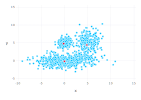

In [461]:
ii+=1
L,P_k↾xs,P_xs=E_step(xs, μs,Σs, P_ks)

println("$ii: $L : $(log(L))")
μs,Σs, P_ks= M_step(xs, P_k↾xs)
println(μs,Σs)

if M==1
    uu = hcat(μs...)
    ss = hcat(Σs...)
    plot(
        layer(x=xs,Geom.histogram,xintercept=[uu], Geom.vline(color="red")),
        layer(x=xs,Geom.histogram,xintercept=[uu-ss uu+ss], Geom.vline(color="orange"))
    )
elseif M==2
    plot(
        layer(x=μs[:,1], y=μs[:,2],Geom.point, Theme(default_color=color("#FF0022"))),
        layer(x=xs[:,1], y=xs[:,2],Geom.point)
        )
end

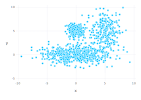

In [453]:
cdata = [randn(250,2).*[√2 √4]+5; randn(500,2).*[√10 √1]; randn(250,2).*√0.5.+[0 5]]''

p=plot(x=cdata[:,1], y=cdata[:,2], Geom.point)

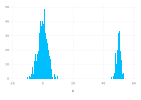

In [447]:
using Gadfly
bdata = [randn(250,1)*√2+50; randn(750,1)*√10]''

plot(x=bdata, Geom.histogram)
